In [1]:
try:
    import google.colab

    IN_COLAB = True
except:
    IN_COLAB = False
if IN_COLAB:
    !pip install -q transformers
    from google.colab import drive

    drive.mount('/content/drive')
    import sys

    sys.path.append('/content/drive/MyDrive/gan_bert_for_cpv')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 91.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 27.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 110.6 MB/s eta 0:00:00
Mounted at /content/drive


In [2]:
from transformers import logging

logging.set_verbosity_error()
import torch
from create_dataset import CreateDataset
from process_data import ProcessData
from utils import *
from torch.utils.data import DataLoader
from run_model import RunModel
from models import BertGenerator, BertDiscriminator
from transformers import AutoTokenizer, AutoModel, AutoConfig

In [3]:
from models import *

In [4]:
Classifiers = [EmbeddingClassifier, HiddenClassifier1, HiddenClassifier2, HiddenClassifier3, HiddenClassifier4,
               HiddenClassifier5, HiddenClassifier6, HiddenClassifier7, HiddenClassifier8, HiddenClassifier9,
               HiddenClassifier10, HiddenClassifier11, HiddenClassifier12]

In [5]:
label_column = "afdeling"
text_column = "Korte beschrijving aanbesteding"
input_df = pd.read_csv("/content/drive/MyDrive/gan_bert_for_cpv/data/cleaned_dutch_ted1.csv")

In [6]:
vc = input_df[label_column].value_counts()
down_sample_vc = vc[vc.values < 1500]
input_df = input_df[input_df[label_column].isin(down_sample_vc.index)]

In [7]:
running_device = torch.device("cuda")

In [8]:
prd = ProcessData(input_df, label_column, text_column, sample_num=1000, aug_limit=1000, test_per_label_num=30,
                  drop_limit=50,
                  balanced_test=True)
suf_df,insuf_df,_, label_encoder, onehot = prd.process()
train_df = pd.read_csv("/content/drive/MyDrive/gan_bert_for_cpv/data/sampled_train.csv")
test_df = pd.read_csv("/content/drive/MyDrive/gan_bert_for_cpv/data/sampled_test.csv")
suf_df, insuf_df = prd._split_sufficient_insufficient(train_df)

After removing duplicate sentence: 16897
After drop cpv with low observations we have : 16803
The num of class is  30
The number of total data is:  15992
Total number of test data is:  900
Total number of train data is:  15092


In [9]:
value_counts = insuf_df[label_column].value_counts()
model_runner = RunModel(running_device)

In [10]:
train_df[label_column].value_counts()

Furniture (incl. Meubelen (m.i.v. kantoormeubelen), inrichtingsartikelen, huishoudelijke apparaten (uitgez. verlichting) en schoonmaakproducten    970
Medische apparatuur, farmaceutische artikelen en artikelen voor lichaamsverzorging                                                                 970
Aardolieproducten, brandstof, elektriciteit en andere energiebronnen                                                                               970
Vervoersdiensten (uitg. vervoer van afval)                                                                                                         921
Diensten voor onderwijs en opleiding                                                                                                               841
Radio-, televisie-, communicatie-, telecommunicatietoestellen en aanverwante apparatuur                                                            816
Overige gemeenschaps-,  sociale en persoonlijke diensten                                      

In [11]:
tokenizer = AutoTokenizer.from_pretrained("GroNLP/bert-base-dutch-cased")
config = AutoConfig.from_pretrained("GroNLP/bert-base-dutch-cased", output_hidden_states=True)
bert = AutoModel.from_pretrained("GroNLP/bert-base-dutch-cased", config=config).to(running_device)

In [12]:
aug_limits = decide_aug_labels(True, 970, value_counts,0.5)

In [13]:
aug_limits

{'Vervoersdiensten (uitg. vervoer van afval)': 49,
 'Diensten voor onderwijs en opleiding': 129,
 'Radio-, televisie-, communicatie-, telecommunicatietoestellen en aanverwante apparatuur': 154,
 'Overige gemeenschaps-,  sociale en persoonlijke diensten': 177,
 'Laboratoriuminstrumenten, optische en precisie-instrumenten (uitgezonderd brillen)': 188,
 'Structuren en materialen voor de bouw; ondersteunende producten voor de bouw (uitgezonderd elektrische apparatuur)': 201,
 'Onderzoek en ontwikkeling, en aanverwante adviezen': 217,
 'Bedrijfsmachines': 231,
 'Post- en telecommunicatiediensten': 329,
 'Drukwerk en aanverwante producten': 404,
 'Kleding, schoeisel, bagageartikelen en accessoires': 422,
 'Diensten voor openbaar bestuur, defensie en sociale verzekering': 432,
 'Uitrusting voor veiligheid, brandweer, politie en leger': 537,
 'Cultuur-, sport- en recreatiediensten': 570,
 'Diensten voor hotel, restaurant en detailhandel': 571,
 'Elektrische machines, apparaten, uitrusting en v

In [14]:
ACCs = []
F1s = []
Precisions = []
Recalls = []
Label_f1s = []
for layer_index in range(13):
    cd = CreateDataset(text_column, label_column, label_encoder, onehot, layer_index, running_device, max_length=120)
    test_dataset = cd.create(test_df)
    test_dl = DataLoader(test_dataset, shuffle=True, batch_size=20)
    insuf_ds_dict = cd.create_label_dataset(insuf_df)
    insuf_ds_list = list(insuf_ds_dict.values())
    augmented_ds_lists = model_runner.augment_data(bert, aug_limits, insuf_ds_dict)
    gan_aug_train_dataset = torch.utils.data.ConcatDataset(augmented_ds_lists + insuf_ds_list)
    gan_train_dl = DataLoader(gan_aug_train_dataset, shuffle=True, batch_size=20)
    Classifier = Classifiers[layer_index]
    classifier = Classifier(prd.num_class, bert)
    classifier = model_runner.train_classifier(gan_train_dl, test_dl, classifier, lr=1e-5, n_epochs=6)
    predictions, labels = model_runner.predict(test_dl, classifier)
    acc, f1, precision, recall, label_f1 = evaluate(labels, predictions)
    ACCs.append(acc)
    F1s.append(f1)
    Precisions.append(precision)
    Recalls.append(recall)
    Label_f1s.append(label_f1)

Getting bert hidden states from layer: 0: 100%|██████████| 153/153 [00:01<00:00, 79.60it/s]


We have: 27 labels to be augmented


100%|██████████| 1444/1444 [10:07<00:00,  2.38it/s]


0 train loss:  2.227492263236204 val acc:  0.4911111228995853


100%|██████████| 1444/1444 [10:09<00:00,  2.37it/s]


1 train loss:  0.8614003386895412 val acc:  0.5866666800445981


100%|██████████| 1444/1444 [10:10<00:00,  2.37it/s]


2 train loss:  0.5710327767707676 val acc:  0.6044444580872853


100%|██████████| 1444/1444 [10:10<00:00,  2.37it/s]


3 train loss:  0.44382993352194405 val acc:  0.6255555742316776


100%|██████████| 1444/1444 [10:09<00:00,  2.37it/s]


4 train loss:  0.35419566852783585 val acc:  0.6366666787200503


100%|██████████| 1444/1444 [10:11<00:00,  2.36it/s]


5 train loss:  0.2902882950766776 val acc:  0.637777794069714


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.638
F1: 0.604
Precision: 0.620
Recall: 0.638


Getting bert hidden states from layer: 1: 100%|██████████| 153/153 [00:01<00:00, 78.11it/s]


We have: 27 labels to be augmented


100%|██████████| 1444/1444 [09:18<00:00,  2.59it/s]


0 train loss:  2.0929041035948037 val acc:  0.4822222332159678


100%|██████████| 1444/1444 [09:17<00:00,  2.59it/s]


1 train loss:  0.8072249562920708 val acc:  0.603333345386717


100%|██████████| 1444/1444 [09:17<00:00,  2.59it/s]


2 train loss:  0.4929685030710417 val acc:  0.6111111223697663


100%|██████████| 1444/1444 [09:16<00:00,  2.60it/s]


3 train loss:  0.3485662092214806 val acc:  0.6155555678738488


100%|██████████| 1444/1444 [09:15<00:00,  2.60it/s]


4 train loss:  0.24604240109901515 val acc:  0.6433333483007219


100%|██████████| 1444/1444 [09:15<00:00,  2.60it/s]


5 train loss:  0.17877951509530793 val acc:  0.6522222366597917


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.652
F1: 0.635
Precision: 0.669
Recall: 0.652


Getting bert hidden states from layer: 2: 100%|██████████| 153/153 [00:01<00:00, 84.80it/s]


We have: 27 labels to be augmented


100%|██████████| 1444/1444 [08:23<00:00,  2.87it/s]


0 train loss:  2.2135272141638884 val acc:  0.5088888986243142


100%|██████████| 1444/1444 [08:23<00:00,  2.87it/s]


1 train loss:  0.9551396253944434 val acc:  0.5733333494928148


100%|██████████| 1444/1444 [08:25<00:00,  2.86it/s]


2 train loss:  0.6941907891018156 val acc:  0.5955555703904893


100%|██████████| 1444/1444 [08:23<00:00,  2.87it/s]


3 train loss:  0.5620591217920267 val acc:  0.6055555688010321


100%|██████████| 1444/1444 [08:24<00:00,  2.86it/s]


4 train loss:  0.46450642586706353 val acc:  0.6300000091393788


100%|██████████| 1444/1444 [08:23<00:00,  2.87it/s]


5 train loss:  0.39672207353711436 val acc:  0.6111111210452186


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.611
F1: 0.585
Precision: 0.607
Recall: 0.611


Getting bert hidden states from layer: 3: 100%|██████████| 153/153 [00:01<00:00, 79.67it/s]


We have: 27 labels to be augmented


100%|██████████| 1444/1444 [07:32<00:00,  3.19it/s]


0 train loss:  2.1538033847622264 val acc:  0.46777778598997327


100%|██████████| 1444/1444 [07:32<00:00,  3.19it/s]


1 train loss:  0.911327037310171 val acc:  0.5788888951142629


100%|██████████| 1444/1444 [07:33<00:00,  3.19it/s]


2 train loss:  0.6812430240131316 val acc:  0.5933333423402575


100%|██████████| 1444/1444 [07:33<00:00,  3.18it/s]


3 train loss:  0.48643473606076804 val acc:  0.6355555673440297


100%|██████████| 1444/1444 [07:33<00:00,  3.18it/s]


4 train loss:  0.28553084361849357 val acc:  0.6466666824287839


100%|██████████| 1444/1444 [07:33<00:00,  3.18it/s]


5 train loss:  0.20091455668040714 val acc:  0.6533333500226338


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.653
F1: 0.633
Precision: 0.648
Recall: 0.653


Getting bert hidden states from layer: 4: 100%|██████████| 153/153 [00:01<00:00, 82.50it/s]


We have: 27 labels to be augmented


100%|██████████| 1444/1444 [06:42<00:00,  3.59it/s]


0 train loss:  2.2003803485978675 val acc:  0.4700000113911099


100%|██████████| 1444/1444 [06:42<00:00,  3.58it/s]


1 train loss:  0.944504033701902 val acc:  0.5688889006773631


100%|██████████| 1444/1444 [06:42<00:00,  3.58it/s]


2 train loss:  0.6470781144353244 val acc:  0.5888889021343655


100%|██████████| 1444/1444 [06:42<00:00,  3.59it/s]


3 train loss:  0.5045003314964329 val acc:  0.6044444587495592


100%|██████████| 1444/1444 [06:42<00:00,  3.58it/s]


4 train loss:  0.40287612114808524 val acc:  0.5822222358650632


100%|██████████| 1444/1444 [06:43<00:00,  3.58it/s]


5 train loss:  0.3206962900496813 val acc:  0.6200000094042883


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.620
F1: 0.583
Precision: 0.596
Recall: 0.620


Getting bert hidden states from layer: 5: 100%|██████████| 153/153 [00:01<00:00, 83.72it/s]


We have: 27 labels to be augmented


100%|██████████| 1444/1444 [05:50<00:00,  4.12it/s]


0 train loss:  2.0803552360746007 val acc:  0.4711111201180352


100%|██████████| 1444/1444 [05:51<00:00,  4.11it/s]


1 train loss:  0.8414093563513743 val acc:  0.587777790096071


100%|██████████| 1444/1444 [05:50<00:00,  4.11it/s]


2 train loss:  0.5852322248855497 val acc:  0.6166666785875956


100%|██████████| 1444/1444 [05:50<00:00,  4.11it/s]


3 train loss:  0.45164482842052456 val acc:  0.6233333455191719


100%|██████████| 1444/1444 [05:50<00:00,  4.12it/s]


4 train loss:  0.347050424026702 val acc:  0.6311111191908518


100%|██████████| 1444/1444 [05:50<00:00,  4.12it/s]


5 train loss:  0.2700328519051879 val acc:  0.6222222361299726


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.622
F1: 0.599
Precision: 0.634
Recall: 0.622


Getting bert hidden states from layer: 6: 100%|██████████| 153/153 [00:01<00:00, 81.42it/s]


We have: 27 labels to be augmented


100%|██████████| 1444/1444 [04:58<00:00,  4.83it/s]


0 train loss:  2.1898833510370466 val acc:  0.47333334220780265


100%|██████████| 1444/1444 [04:58<00:00,  4.84it/s]


1 train loss:  0.8892410895645289 val acc:  0.5755555642975702


100%|██████████| 1444/1444 [04:59<00:00,  4.83it/s]


2 train loss:  0.6405624352818629 val acc:  0.5988889025317298


100%|██████████| 1444/1444 [04:58<00:00,  4.83it/s]


3 train loss:  0.5061835569285702 val acc:  0.5877777894337972


100%|██████████| 1444/1444 [04:59<00:00,  4.83it/s]


4 train loss:  0.409184603099234 val acc:  0.6033333526717292


100%|██████████| 1444/1444 [04:59<00:00,  4.82it/s]


5 train loss:  0.3364434308157021 val acc:  0.6144444558355543


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.614
F1: 0.577
Precision: 0.558
Recall: 0.614


Getting bert hidden states from layer: 7: 100%|██████████| 153/153 [00:01<00:00, 79.56it/s]


We have: 27 labels to be augmented


100%|██████████| 1444/1444 [04:07<00:00,  5.83it/s]


0 train loss:  2.23329984609275 val acc:  0.42777778440051606


100%|██████████| 1444/1444 [04:07<00:00,  5.83it/s]


1 train loss:  1.1210356749429102 val acc:  0.5055555681387583


100%|██████████| 1444/1444 [04:07<00:00,  5.83it/s]


2 train loss:  0.871289234200797 val acc:  0.5266666776604123


100%|██████████| 1444/1444 [04:07<00:00,  5.83it/s]


3 train loss:  0.7500940897937998 val acc:  0.5400000148349338


100%|██████████| 1444/1444 [04:07<00:00,  5.82it/s]


4 train loss:  0.6504922930584638 val acc:  0.555555569463306


100%|██████████| 1444/1444 [04:07<00:00,  5.83it/s]


5 train loss:  0.569474328157087 val acc:  0.5588889035913679


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.559
F1: 0.512
Precision: 0.506
Recall: 0.559


Getting bert hidden states from layer: 8: 100%|██████████| 153/153 [00:01<00:00, 87.07it/s]


We have: 27 labels to be augmented


100%|██████████| 1444/1444 [03:15<00:00,  7.38it/s]


0 train loss:  2.2354920874465867 val acc:  0.40888889498180814


100%|██████████| 1444/1444 [03:16<00:00,  7.36it/s]


1 train loss:  1.13587636208559 val acc:  0.5233333455191718


100%|██████████| 1444/1444 [03:15<00:00,  7.39it/s]


2 train loss:  0.9046782777203541 val acc:  0.5311111198531256


100%|██████████| 1444/1444 [03:16<00:00,  7.37it/s]


3 train loss:  0.7557347080363296 val acc:  0.5577777915530735


100%|██████████| 1444/1444 [03:16<00:00,  7.36it/s]


4 train loss:  0.537545698138929 val acc:  0.5911111275355021


100%|██████████| 1444/1444 [03:16<00:00,  7.36it/s]


5 train loss:  0.3520058671262765 val acc:  0.6122222363948822


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.612
F1: 0.584
Precision: 0.599
Recall: 0.612


Getting bert hidden states from layer: 9: 100%|██████████| 153/153 [00:01<00:00, 79.25it/s]


We have: 27 labels to be augmented


100%|██████████| 1444/1444 [02:26<00:00,  9.89it/s]


0 train loss:  2.2836519438886906 val acc:  0.41222222910987005


100%|██████████| 1444/1444 [02:26<00:00,  9.89it/s]


1 train loss:  1.0307375719342535 val acc:  0.5144444545110066


100%|██████████| 1444/1444 [02:26<00:00,  9.89it/s]


2 train loss:  0.7862524416328632 val acc:  0.5422222336133321


100%|██████████| 1444/1444 [02:26<00:00,  9.89it/s]


3 train loss:  0.6531989780432671 val acc:  0.5600000129805671


100%|██████████| 1444/1444 [02:26<00:00,  9.89it/s]


4 train loss:  0.5528035604309838 val acc:  0.5477777911557091


100%|██████████| 1444/1444 [02:25<00:00,  9.89it/s]


5 train loss:  0.46406973452291805 val acc:  0.6000000092718336


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.600
F1: 0.558
Precision: 0.562
Recall: 0.600


Getting bert hidden states from layer: 10: 100%|██████████| 153/153 [00:02<00:00, 72.93it/s]


We have: 27 labels to be augmented


100%|██████████| 1444/1444 [01:33<00:00, 15.50it/s]


0 train loss:  2.4125608653655672 val acc:  0.34111111495229934


100%|██████████| 1444/1444 [01:33<00:00, 15.49it/s]


1 train loss:  1.2096070114141355 val acc:  0.5055555654896631


100%|██████████| 1444/1444 [01:33<00:00, 15.48it/s]


2 train loss:  0.9121839326814106 val acc:  0.5355555660194821


100%|██████████| 1444/1444 [01:33<00:00, 15.47it/s]


3 train loss:  0.7590381803656632 val acc:  0.5555555628405677


100%|██████████| 1444/1444 [01:33<00:00, 15.46it/s]


4 train loss:  0.6662501791321835 val acc:  0.5644444571601019


100%|██████████| 1444/1444 [01:33<00:00, 15.44it/s]


5 train loss:  0.5806337184352681 val acc:  0.5700000094042884


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.570
F1: 0.530
Precision: 0.563
Recall: 0.570


Getting bert hidden states from layer: 11: 100%|██████████| 153/153 [00:01<00:00, 77.26it/s]


We have: 27 labels to be augmented


100%|██████████| 1444/1444 [00:43<00:00, 32.95it/s]


0 train loss:  2.4767323116516473 val acc:  0.27333333773745433


100%|██████████| 1444/1444 [00:43<00:00, 32.98it/s]


1 train loss:  1.2519833997222196 val acc:  0.42222223149405586


100%|██████████| 1444/1444 [00:43<00:00, 32.96it/s]


2 train loss:  0.9650422047741113 val acc:  0.49000000986788006


100%|██████████| 1444/1444 [00:43<00:00, 32.97it/s]


3 train loss:  0.8533546560214332 val acc:  0.5277777890364329


100%|██████████| 1444/1444 [00:43<00:00, 32.98it/s]


4 train loss:  0.7839368898215139 val acc:  0.5555555681387584


100%|██████████| 1444/1444 [00:43<00:00, 32.97it/s]


5 train loss:  0.7153386445677326 val acc:  0.5533333440621694


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.553
F1: 0.514
Precision: 0.510
Recall: 0.553


Getting bert hidden states from layer: 12: 100%|██████████| 153/153 [00:01<00:00, 80.35it/s]


We have: 27 labels to be augmented


100%|██████████| 1444/1444 [00:06<00:00, 233.53it/s]


0 train loss:  2.888316761010902 val acc:  0.046666667693191104


100%|██████████| 1444/1444 [00:06<00:00, 229.63it/s]


1 train loss:  2.0562399730622936 val acc:  0.09444444659683439


100%|██████████| 1444/1444 [00:06<00:00, 236.16it/s]


2 train loss:  1.8810081341177474 val acc:  0.11222222422560056


100%|██████████| 1444/1444 [00:06<00:00, 228.03it/s]


3 train loss:  1.7720410220758407 val acc:  0.1555555591152774


100%|██████████| 1444/1444 [00:06<00:00, 237.92it/s]


4 train loss:  1.7039125534058277 val acc:  0.17222222536802292


100%|██████████| 1444/1444 [00:06<00:00, 225.59it/s]


5 train loss:  1.6489435508640848 val acc:  0.18222222593095566
Total ACC: 0.182
F1: 0.131
Precision: 0.125
Recall: 0.182


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


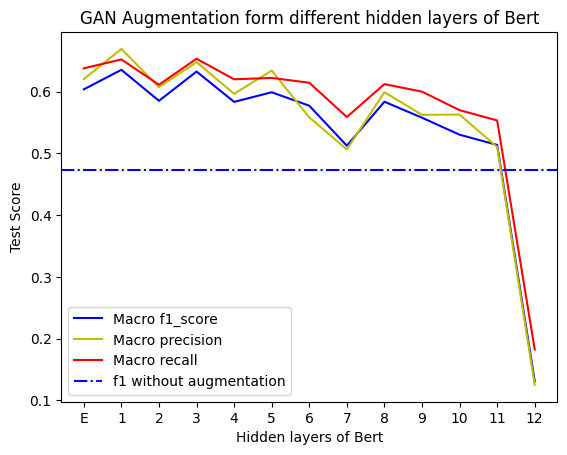

In [15]:
x_label=["E"]+[i for i in range(1,13)]
import matplotlib.pyplot as plt
# plt.plot(ACCs, label="accuracy")
fig = plt.figure(edgecolor='k', frameon=True)
# fig.patch.set_facecolor('xkcd:blue')
plt.plot(F1s, label="Macro f1_score",color='b')
plt.plot(Precisions, label="Macro precision",color='y')
plt.plot(Recalls, label="Macro recall",color='r')
# plt.text(x, y, s, fontdict=None, **kwargs)[source]

plt.axhline(y = 0.473, color = 'b', linestyle = 'dashdot',label="f1 without augmentation")
plt.xticks([i for i in range(13)],x_label)
plt.xlabel("Hidden layers of Bert")
plt.ylabel("Test Score")
plt.title("GAN Augmentation form different hidden layers of Bert")
plt.legend()
plt.show()

In [16]:
all_fls=np.array(Label_f1s)

In [17]:
print(all_fls)

[[0.7761194  0.38461538 0.8        0.72131148 0.82758621 0.73529412
  0.         0.87719298 0.70967742 0.6969697  0.         0.83333333
  0.61111111 0.75409836 0.8        0.         0.75409836 0.59649123
  0.18181818 0.71875    0.47826087 0.59459459 0.37209302 0.5
  0.91803279 0.69565217 0.54285714 0.63768116 0.88235294 0.71186441]
 [0.78571429 0.34090909 0.79245283 0.75       0.82758621 0.82539683
  0.62162162 0.81481481 0.64285714 0.64705882 0.21052632 0.81818182
  0.49275362 0.72131148 0.79245283 0.         0.72727273 0.57142857
  0.28571429 0.77419355 0.55555556 0.64705882 0.34146341 0.56756757
  0.89655172 0.72463768 0.58823529 0.64615385 0.9375     0.71428571]
 [0.80645161 0.42352941 0.6984127  0.70175439 0.81481481 0.
  0.63414634 0.80645161 0.6440678  0.63492063 0.17241379 0.8
  0.51764706 0.70967742 0.82142857 0.         0.72413793 0.55172414
  0.22222222 0.68965517 0.5        0.625      0.36842105 0.56470588
  0.83333333 0.57575758 0.53164557 0.59259259 0.90909091 0.68      ]

In [18]:
label_encoder.inverse_transform([i for i in range(prd.num_class)])

array(['Aardolieproducten, brandstof, elektriciteit en andere energiebronnen',
       'Bedrijfsmachines', 'Chemische producten',
       'Cultuur-, sport- en recreatiediensten',
       'Diensten voor hotel, restaurant en detailhandel',
       'Diensten voor onderwijs en opleiding',
       'Diensten voor openbaar bestuur, defensie en sociale verzekering',
       'Drukwerk en aanverwante producten',
       'Elektrische machines, apparaten, uitrusting en verbruiksartikelen. Verlichting',
       'Furniture (incl. Meubelen (m.i.v. kantoormeubelen), inrichtingsartikelen, huishoudelijke apparaten (uitgez. verlichting) en schoonmaakproducten',
       'Installatiediensten (uitgezonderd software)',
       'Kleding, schoeisel, bagageartikelen en accessoires',
       'Laboratoriuminstrumenten, optische en precisie-instrumenten (uitgezonderd brillen)',
       'Landbouw- en veeteelt-, kwekerij-, visserij-, bosbouw- en aanverwante producten',
       'Landbouwmachines',
       'Machines voor de mijnbou

In [19]:
for i in range(prd.num_class):
    label=label_encoder.inverse_transform([i])
    print(list(all_fls[:,i]))
    print(value_counts[label])

[0.7761194029850748, 0.7857142857142856, 0.8064516129032259, 0.761904761904762, 0.7246376811594204, 0.7301587301587302, 0.7936507936507938, 0.6842105263157895, 0.7297297297297297, 0.6388888888888888, 0.6216216216216216, 0.6578947368421053, 0.2073170731707317]
Aardolieproducten, brandstof, elektriciteit en andere energiebronnen    970
Name: afdeling, dtype: int64
[0.3846153846153846, 0.34090909090909094, 0.4235294117647059, 0.45, 0.3950617283950617, 0.4210526315789474, 0.3529411764705882, 0.3902439024390244, 0.42857142857142855, 0.40776699029126207, 0.4444444444444445, 0.31775700934579443, 0.19148936170212766]
Bedrijfsmachines    739
Name: afdeling, dtype: int64
[0.8, 0.7924528301886793, 0.6984126984126984, 0.7777777777777777, 0.7777777777777777, 0.8518518518518519, 0.896551724137931, 0.0, 0.7636363636363636, 0.8076923076923077, 0.7692307692307692, 0.7058823529411764, 0.0]
Chemische producten    167
Name: afdeling, dtype: int64
[0.7213114754098361, 0.7500000000000001, 0.7017543859649122

In [ ]:
cd = CreateDataset(text_column, label_column, label_encoder, onehot, 0, running_device, max_length=120)
test_dataset = cd.create(test_df)
test_dl = DataLoader(test_dataset, shuffle=True, batch_size=20)
insuf_ds_dict = cd.create_label_dataset(insuf_df)
insuf_ds_list = list(insuf_ds_dict.values())
train_dataset = torch.utils.data.ConcatDataset(insuf_ds_list)
train_dl = DataLoader(train_dataset, shuffle=True, batch_size=20)
Classifier = Classifiers[0]
classifier = Classifier(prd.num_class, bert)
classifier = model_runner.train_classifier(train_dl, test_dl, classifier, lr=1e-5, n_epochs=6)
predictions, labels = model_runner.predict(test_dl, classifier)
acc, f1, precision, recall, label_f1 = evaluate(labels, predictions)

100%|██████████| 755/755 [05:18<00:00,  2.37it/s]


0 train loss:  3.205915280525258 val acc:  0.271111114985413


100%|██████████| 755/755 [05:19<00:00,  2.37it/s]


1 train loss:  2.1306281536620184 val acc:  0.4077777836057875


100%|██████████| 755/755 [05:18<00:00,  2.37it/s]


2 train loss:  1.5949111842951238 val acc:  0.5055555681387583


100%|██████████| 755/755 [05:18<00:00,  2.37it/s]


3 train loss:  1.3107098727431519 val acc:  0.5233333461814457


100%|██████████| 755/755 [05:19<00:00,  2.37it/s]


4 train loss:  1.0838200700204104 val acc:  0.5488888998826345


100%|██████████| 755/755 [05:18<00:00,  2.37it/s]


5 train loss:  0.8855548056249587 val acc:  0.5533333460489909
Total ACC: 0.553
F1: 0.497
Precision: 0.466
Recall: 0.553


In [ ]:
from google.colab import runtime
runtime.unassign()